In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [3]:
train = pd.read_parquet("/kaggle/input/avitocup/train.parquet")

# ExploratoryDataAnalysis #

## train ##

In [4]:
train.head()

,user_id,adv_campaign_id,platform_id,adv_creative_id,event_date,banner_code,is_main,target
0,2853707,3352,3,3075,2024-09-17,6,True,0
1,2537244,4029,2,3260,2024-09-17,8,True,0
2,63033,1578,3,1109,2024-09-17,6,True,0
3,164702,3434,1,1079,2024-09-17,7,True,0
4,2802905,2208,3,3576,2024-09-17,6,True,0


In [5]:
# дата события имеет строковый формат
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114741035 entries, 0 to 114741034
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   user_id          int64 
 1   adv_campaign_id  int64 
 2   platform_id      int64 
 3   adv_creative_id  int64 
 4   event_date       object
 5   banner_code      int64 
 6   is_main          bool  
 7   target           int32 
dtypes: bool(1), int32(1), int64(5), object(1)
memory usage: 5.7+ GB


In [10]:
# нет пропущенных значений
train.isna().sum().sum()

0

In [4]:
# задача с сильной диспропорцией классов, объектов целевого класса всего полпроцента 
train.target.value_counts(normalize = True)

target
0    0.99463
1    0.00537
Name: proportion, dtype: float64

In [5]:
# в трейне информация о взаимодействии более 3 млн юзеров с примерно 4 тыс рекламных кампаний
train.user_id.nunique(), train.adv_campaign_id.nunique(), train.adv_creative_id.nunique()

(3263615, 4031, 4291)

In [8]:
# сколько юзеров кликали
train[train.target == 1].user_id.nunique()

399111

In [17]:
# посмотрим как распределяются клики по кампаниям
# три четверти кампаний имеют до 200 кликов за весь период наблюдения
clicks_campaigns = train.groupby('adv_campaign_id', as_index = False).agg({'target' : 'sum'}).rename(columns = {'target' : 'clicks'})
clicks_campaigns.clicks.describe()

count    4031.000000
mean      152.846936
std       230.785812
min         0.000000
25%        16.000000
50%        80.000000
75%       193.000000
max      3674.000000
Name: clicks, dtype: float64

In [18]:
# период наблюдения с 01.09.2024 по 22.09.2024
train.event_date = pd.to_datetime(train.event_date)
train.event_date.min(), train.event_date.max()

(Timestamp('2024-09-01 00:00:00'), Timestamp('2024-09-22 00:00:00'))

Text(0.5, 1.0, 'clicks')

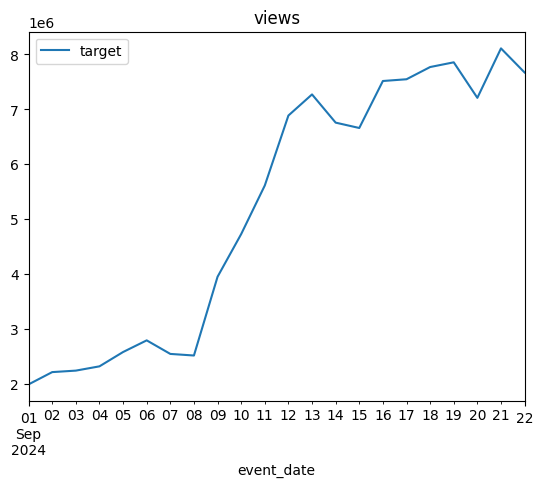

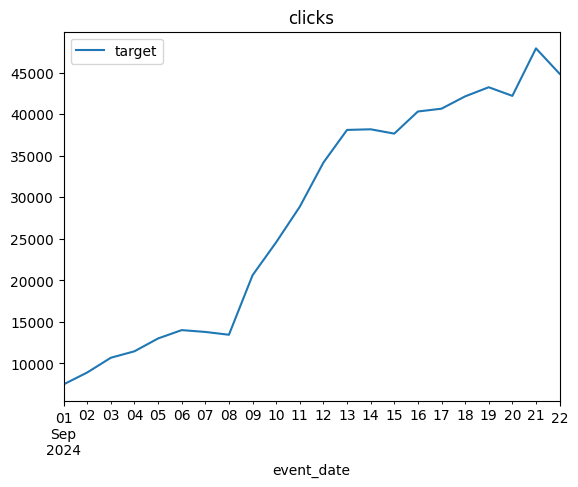

In [47]:
# видно, что общее число просмотров и кликов растет, однако имеются пики
views_date = train.groupby('event_date', as_index = False).agg({'target' : 'count'})
clicks_date = train.groupby('event_date', as_index = False).agg({'target' : 'sum'})
views_date.set_index('event_date').plot()
plt.title('views')
clicks_date.set_index('event_date').plot()
plt.title('clicks')

Text(0.5, 1.0, 'count_adv_campaigns_start')

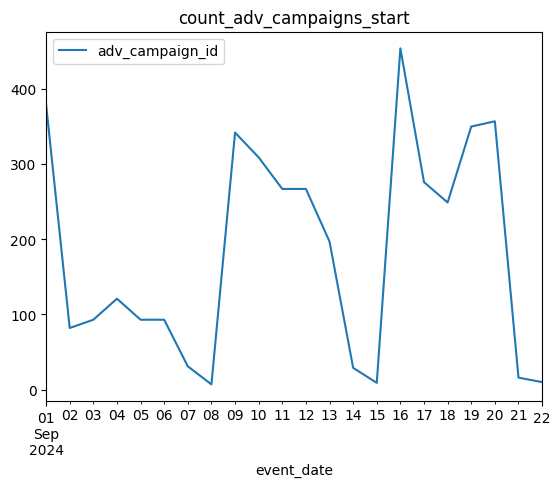

In [48]:
# в общем просмотры и клики коррелируют с тем, какое количество компаний запущено (что логично - больше кампаний значит больше баннеров и больше кликов)
adv_camp_first_dates = train.groupby('adv_campaign_id', as_index = False).agg({'event_date' : 'min'})
adv_camp_first_dates = adv_camp_first_dates.groupby('event_date', as_index = False).agg({'adv_campaign_id' : 'count'}).set_index('event_date')
adv_camp_first_dates.plot()
plt.title('count_adv_campaigns_start')

<Axes: >

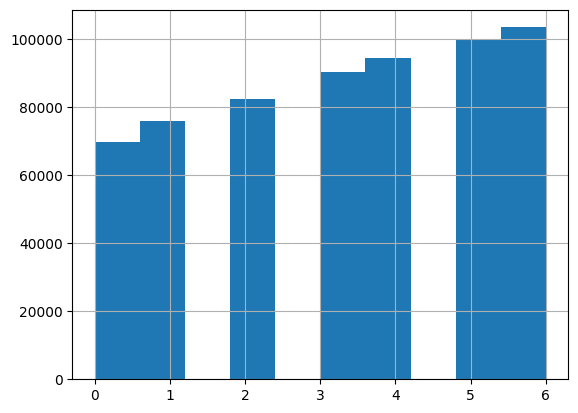

In [51]:
# ближе к выходным пользовательская активность выше
train['day_of_week'] = train.event_date.dt.dayofweek
train[train.target == 1].day_of_week.hist()

In [19]:
# видно, что на каждой платформе размещено 2 баннера
# лучший ctr у второй платформы
# ctr у показов с главной страницы ниже
platform_banner_views = train.groupby(['platform_id', 'banner_code', 'is_main'], as_index = False).agg({'target' : 'count'}).rename(columns = {'target' : 'views'})
platform_banner_clicks = train.groupby(['platform_id', 'banner_code', 'is_main'], as_index = False).agg({'target' : 'sum'}).rename(columns = {'target' : 'clicks'})
platform_banner = platform_banner_views.merge(platform_banner_clicks, on = ['platform_id', 'banner_code', 'is_main'])
platform_banner['ctr'] = platform_banner.clicks * 100 / platform_banner.views
platform_banner

,platform_id,banner_code,is_main,views,clicks,ctr
0,1,2,False,586883,2212,0.376906
1,1,7,True,4622278,17207,0.372262
2,2,5,False,5302138,73104,1.378765
3,2,8,True,74296252,406724,0.547435
4,3,1,False,2297929,28657,1.247079
5,3,6,True,24006607,81465,0.339344
6,4,3,False,736431,1626,0.220795
7,4,4,True,2892517,5131,0.177389


## campaigns ##

In [20]:
camps = pd.read_parquet("/kaggle/input/avitocup/campaigns_meta.parquet.parquet")

In [68]:
# информация по рекламным кампаниям
camps.head()

,adv_campaign_id,start_date,end_date,goal_cost,goal_budget,location_id,logcat_id
0,2153,2024-09-21,2024-10-02,6.661659,9429.056096,70,59
1,3103,2024-09-10,2024-09-16,2.853378,3844.482933,30,40
2,2816,2024-09-10,2024-09-17,3.058230,1455.156612,56,65
3,3603,2024-09-10,2024-09-16,4.395015,2592.232475,30,50
4,1328,2024-09-10,2024-09-16,3.891329,2836.139672,30,51


In [69]:
# пропущенных значений нет
# даты имеют строковый формат
camps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4031 entries, 0 to 4030
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   adv_campaign_id  4031 non-null   int64  
 1   start_date       4031 non-null   object 
 2   end_date         4031 non-null   object 
 3   goal_cost        4031 non-null   float64
 4   goal_budget      4031 non-null   float64
 5   location_id      4031 non-null   int64  
 6   logcat_id        4031 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 220.6+ KB


In [70]:
# все те же 4031 кампания из трейна, проведенные по 37 логическим категориям на 79 локациях
camps.adv_campaign_id.nunique(), camps.location_id.nunique(), camps.logcat_id.nunique()

(4031, 79, 37)

In [93]:
# каждый товар из рекламы принадлежит одной и только одной логической категории
camps.groupby('adv_campaign_id', as_index = False).agg({'logcat_id' : 'nunique'}).logcat_id.value_counts()

logcat_id
1    4031
Name: count, dtype: int64

In [21]:
# преобразуем даты начала и конца кампаний, вытащим из них доп фичи
camps.start_date = pd.to_datetime(camps.start_date)
camps['start_dayofweek'] = camps['start_date'].dt.dayofweek
camps['start_quarter'] = camps['start_date'].dt.quarter
camps['start_month'] = camps['start_date'].dt.month
camps['start_year'] = camps['start_date'].dt.year
camps['start_dayofyear'] = camps['start_date'].dt.dayofyear
camps['start_dayofmonth'] = camps['start_date'].dt.day

camps.end_date = pd.to_datetime(camps.end_date)
camps['end_dayofweek'] = camps['end_date'].dt.dayofweek
camps['end_quarter'] = camps['end_date'].dt.quarter
camps['end_month'] = camps['end_date'].dt.month
camps['end_year'] = camps['end_date'].dt.year
camps['end_dayofyear'] = camps['end_date'].dt.dayofyear
camps['end_dayofmonth'] = camps['end_date'].dt.day

# учтем длительность кампании
camps['camp_length'] = (camps.end_date - camps.start_date).dt.days
# учтем примерное число кликов, на которые расчитывает рекламодатель
camps['click_budget'] = camps.goal_budget / camps.goal_cost

camps.drop(columns = ['start_date', 'end_date', 'goal_budget'], inplace = True)

In [8]:
camps.head(3)

,adv_campaign_id,goal_cost,location_id,logcat_id,start_dayofweek,start_quarter,start_month,start_year,start_dayofyear,start_dayofmonth,end_dayofweek,end_quarter,end_month,end_year,end_dayofyear,end_dayofmonth,camp_length,click_budget
0,2153,6.661659,70,59,5,3,9,2024,265,21,2,4,10,2024,276,2,11,1415.421542
1,3103,2.853378,30,40,1,3,9,2024,254,10,0,3,9,2024,260,16,6,1347.344476
2,2816,3.058230,56,65,1,3,9,2024,254,10,1,3,9,2024,261,17,7,475.816538


## categories ##

In [22]:
cats = pd.read_parquet("/kaggle/input/avitocup/categories.parquet.csv.parquet")

In [65]:
cats.head()

,microcat_id,level_id,parent_microcat_id,logcat_id,vertical_id,category_id
0,33482,7.0,40172.0,54.0,3.0,3.0
1,27254,5.0,48637.0,55.0,5.0,4.0
2,37005,6.0,15332.0,54.0,3.0,3.0
3,31376,8.0,28137.0,58.0,8.0,4.0
4,20493,4.0,18343.0,24.0,8.0,9.0


In [81]:
# имеются пропущенные значения
cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25891 entries, 0 to 25890
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   microcat_id         25891 non-null  int64  
 1   level_id            25890 non-null  float64
 2   parent_microcat_id  25888 non-null  float64
 3   logcat_id           25883 non-null  float64
 4   vertical_id         25883 non-null  float64
 5   category_id         25887 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 1.2 MB


In [84]:
cats.isna().sum()

microcat_id           0
level_id              1
parent_microcat_id    3
logcat_id             8
vertical_id           8
category_id           4
dtype: int64

In [86]:
cats.microcat_id.nunique(),cats.logcat_id.nunique(), cats.vertical_id.nunique(), cats.category_id.nunique()

(25891, 66, 9, 12)

Рассматриваемые данные представляют из себя информацию о микрокатегориях товаров (их всего чуть более 25 тысяч, разбитых на 66 логических категорий). Поскольку мы не знаем, какой именно товар рекламируется, а знаем только его логическую категорию, можно вытащить из этих данных что-то про логкэты (их размер, число вертикалей и тд)

In [23]:
# для анализа данных по категориям добавим данные таргета
adv_logcat = camps[['adv_campaign_id', 'logcat_id']]
clicks_logcat = adv_logcat.merge(clicks_campaigns, on = 'adv_campaign_id').groupby('logcat_id', as_index = False).agg({'clicks' : 'sum'})
clicks_cats = cats.merge(clicks_logcat, on = 'logcat_id')
clicks_cats.head()

,microcat_id,level_id,parent_microcat_id,logcat_id,vertical_id,category_id,clicks
0,20493,4.0,18343.0,24.0,8.0,9.0,90
1,3745,4.0,18343.0,24.0,8.0,9.0,90
2,613,4.0,31073.0,30.0,8.0,8.0,22993
3,30113,5.0,22169.0,9.0,5.0,4.0,4141
4,49758,6.0,9390.0,26.0,8.0,6.0,34732


In [24]:
clicks_cats.groupby('level_id', as_index = False).agg({'clicks' : 'mean'}).sort_values(by = 'clicks')

,level_id,clicks
2,4.0,13317.712018
0,2.0,13744.200000
1,3.0,15666.628571
3,5.0,40772.911336
4,6.0,56573.596811
5,7.0,106621.685343
6,8.0,120764.000000


In [35]:
clicks_cats.groupby('vertical_id', as_index = False).agg({'clicks' : 'mean'}).sort_values(by = 'clicks')

,vertical_id,clicks
0,3.0,5948.656250
1,4.0,10851.207650
4,9.0,49844.000000
3,8.0,55067.865878
2,5.0,66759.201975


In [36]:
clicks_cats.groupby('category_id', as_index = False).agg({'clicks' : 'mean'}).sort_values(by = 'clicks')

,category_id,clicks
8,9.0,92.835714
6,7.0,1636.042945
2,3.0,5948.656250
1,2.0,9888.514286
9,11.0,18523.869403
7,8.0,22406.235294
5,6.0,31166.715474
0,1.0,49844.000000
4,5.0,68954.531973
3,4.0,70054.689576


Видно, что:  
- на 7 и 8 уровнях кликов значительно больше, нежели на остальных
- на 3 вертикали меньше всего кликов
- в категориях 7 и 9 в сравнении с остальными так же мало кликов

In [25]:
cats['top_level_id'] = np.where((cats.level_id == 7) | (cats.level_id == 8), 1, 0)
cats['top_vertical_id'] = np.where(cats.vertical_id != 3, 1, 0)
cats['top_category_id'] = np.where((cats.category_id != 7) & (cats.category_id != 9), 1, 0)

cats_logcat = cats.groupby('logcat_id', as_index= False) \
.agg({'microcat_id' : 'nunique', 'level_id' : 'nunique', 'top_level_id' : 'sum', 
      'parent_microcat_id' : 'nunique', 'vertical_id' : 'nunique', 'top_vertical_id' : 'sum', 
      'category_id' : 'nunique', 'top_category_id' : 'sum'})

In [75]:
cats_logcat.head()

,logcat_id,microcat_id,level_id,top_level_id,parent_microcat_id,vertical_id,top_vertical_id,category_id,top_category_id
0,1.0,5,2,0,2,1,5,1,5
1,2.0,25,2,0,3,1,25,1,25
2,3.0,195,3,0,29,1,195,1,195
3,4.0,35,3,0,7,1,35,1,35
4,5.0,500,4,418,146,1,500,1,500


In [26]:
camps_cats = camps.merge(cats_logcat, on = 'logcat_id')

## FeatureEngineering ##  

На полном трейне посчитаем счетчики для каждой кампании:  
1. средний CTR
2. количество и долю дней, в которых были клики
3. среднюю долю кликнутых объявлений по юзерам

In [27]:
views_campaigns = train.groupby('adv_campaign_id', as_index = False).agg({'target' : 'count'}).rename(columns = {'target' : 'views'})
counter_campaigns = clicks_campaigns.merge(views_campaigns)
counter_campaigns['ctr'] = counter_campaigns.clicks / counter_campaigns.views
adv_days_views = train.groupby('adv_campaign_id', as_index = False) \
.agg({'event_date' : 'nunique'}).rename(columns = {'event_date' : 'days_with_views'})
adv_days_clicks = train.query('target == 1').groupby('adv_campaign_id', as_index = False) \
.agg({'event_date' : 'nunique'}).rename(columns = {'event_date' : 'days_with_ckicks'})
counter_days_adv = adv_days_views.merge(adv_days_clicks).fillna(0)
counter_days_adv['days_with_clicks_share'] = counter_days_adv.days_with_ckicks / counter_days_adv.days_with_views
counters = counter_campaigns.merge(counter_days_adv)
counters.drop(['clicks', 'views', 'days_with_views'], axis = 1, inplace = True)
counters.head()

,adv_campaign_id,ctr,days_with_ckicks,days_with_clicks_share
0,1,0.005162,5,0.454545
1,2,0.006541,3,1.000000
2,3,0.000905,1,0.142857
3,4,0.008180,3,0.750000
4,5,0.025641,3,0.500000


In [28]:
# итоговый трейн
active_users = train[train.target == 1].user_id.unique()
train_df = train[train.user_id.isin(active_users)]
train_df = train_df.merge(counters, on = 'adv_campaign_id', how = 'left').merge(camps_cats, on = 'adv_campaign_id', how = 'left')

## TrainModel ##

In [35]:
X = train_df.drop(columns = ['target'])
y = train_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y, random_state=42)

In [60]:
model = CatBoostClassifier(objective = 'CrossEntropy', verbose  = False, random_state=42)
model.fit(X_train, y_train)

In [61]:
# метрика на валидации
y_pred = model.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred[:,1]))

0.6436007862620002


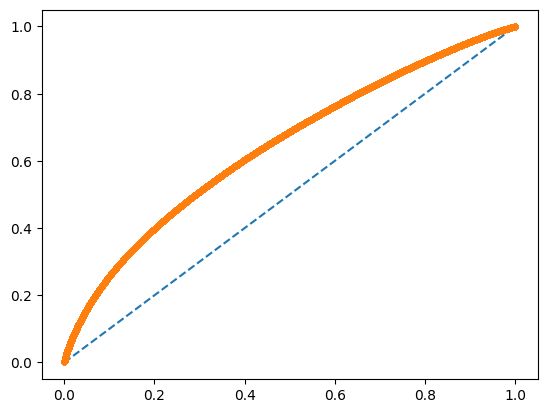

In [68]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_test, y_pred[:,1])

plt.plot([0,1], [0,1], linestyle = '--')
plt.plot(fpr, tpr, marker = '.')
plt.show()